# Install Dependences

In [1]:
!pip install tensorflow==2.18.0
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html
!git clone https://github.com/RR-project-group/TC-AcceleratedMonteCarloSimulation.git

Looking in links: https://storage.googleapis.com/libtpu-tf-releases/index.html
ERROR: Could not find a version that satisfies the requirement tensorflow-tpu==2.18.0 (from versions: 0.0.1rc0)
ERROR: No matching distribution found for tensorflow-tpu==2.18.0
Cloning into 'TC-AcceleratedMonteCarloSimulation'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 186 (delta 32), reused 39 (delta 30), pack-reused 138 (from 1)
Receiving objects: 100% (186/186), 8.01 MiB | 6.40 MiB/s, done.
Resolving deltas: 100% (66/66), done.


# Import library

In [2]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import pandas as pd
os.chdir('TC-AcceleratedMonteCarloSimulation')

# Detect ColabTPU

In [3]:
# ===== Detect TPU or fallback to CPU/GPU =====
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy(resolver)
    print("✅ TPU Detected.")
    tpu_available = True
except:
    tpu_strategy = tf.distribute.get_strategy()
    print("⚠️ TPU Not Found, running on CPU/GPU.")
    tpu_available = False

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
⚠️ TPU Not Found, running on CPU/GPU.


# BS simulation


📊 Benchmark Results:
         label    dtype  n_steps     price
0  CPU-float32  float32       25  3.248831
1  CPU-float32  float32       50  3.244730
2  CPU-float32  float32      100  3.248410


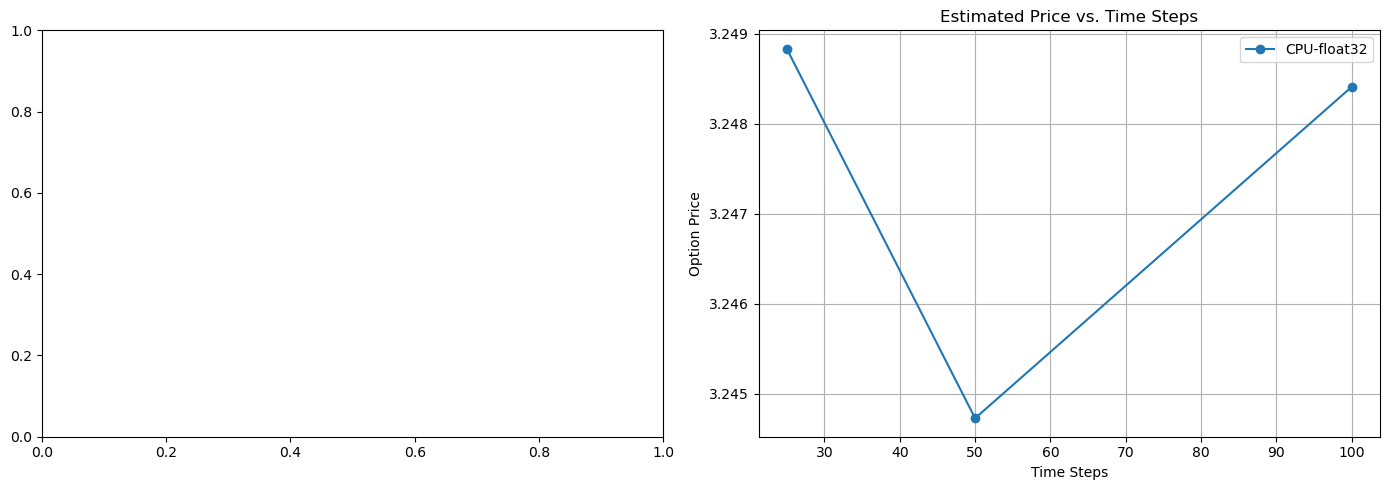

In [4]:
from bs import run_bs_simulation
import pandas as pd

# ===== Parameter Configuration =====
n_steps_list = [25, 50, 100]
n_paths = 10_000_000
dtype = tf.bfloat16
seed = (42, 42)

# ===== Run Experiment in Specific Strategy Context =====
def run_experiment(dtype, n_steps, label):
        price = run_bs_simulation(n_paths, n_steps, dtype=dtype, seed=seed)
        return {
            "label": label,
            "dtype": str(dtype.name),
            "n_steps": n_steps,
            "price": float(price.numpy()),
        }

# ===== Run all configurations =====
results = []

# CPU/GPU: float32 only
for n_steps in n_steps_list:
    result = run_experiment(tf.float32, n_steps, "CPU-float32")
    results.append(result)

# TPU tests: float32 and bfloat16


if tpu_available:
    for n_steps in n_steps_list:
        tf.keras.backend.clear_session()
        with tpu_strategy.scope():
            result = run_experiment(tf.bfloat16, n_steps, f"TPU-{dtype.name}")
        results.append(result)
        print(n_steps)

# ===== Display Results =====
df = pd.DataFrame(results)
print("\n📊 Benchmark Results:")
print(df)

# ===== Optional: Plotting =====
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Option Price Plot
for key, grp in df.groupby('label'):
    ax[1].plot(grp['n_steps'], grp['price'], marker='o', label=key)
ax[1].set_title("Estimated Price vs. Time Steps")
ax[1].set_xlabel("Time Steps")
ax[1].set_ylabel("Option Price")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# LMM simulation

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.

Running with 4000 paths...
MSE: 3.794241e-03

Running with 16000 paths...
MSE: 3.742109e-03

Running with 64000 paths...
MSE: 3.745831e-03

Running with 256000 paths...
MSE: 3.750290e-03


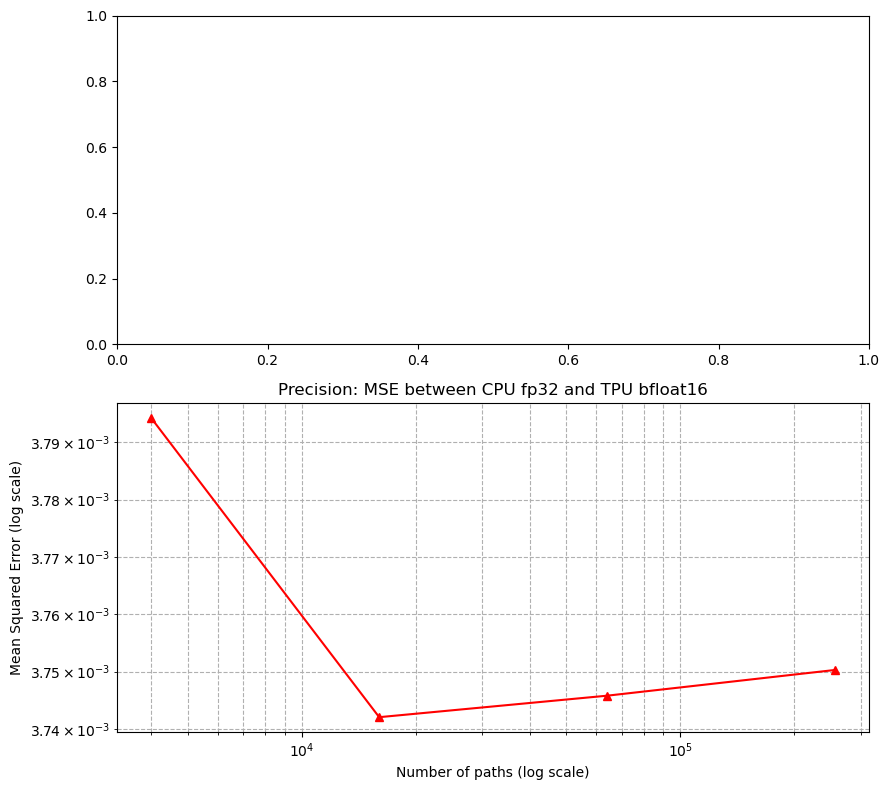

In [5]:
# Disable eager execution for performance
tf.config.experimental_run_functions_eagerly(False)

from lmm import generate_correlation_matrix, simulate_lmm_paths

N = 10
T = 50

corr_np = generate_correlation_matrix(N)
cov_np = corr_np

path_list = [4000, 16000, 64000, 256000]
cpu_times, tpu_times, mse_list = [], [], []

for p in path_list:
    print(f"\nRunning with {p} paths...")

    # CPU fp32
    with tf.device('/CPU:0'):
        res_fp32 = simulate_lmm_paths(tf.constant(cov_np, dtype=tf.float32), p, T, N, tf.float32)

    # TPU bfloat16
    if tpu_strategy is not None:
        with tpu_strategy.scope():
            res_bf16 = simulate_lmm_paths(tf.constant(cov_np, dtype=tf.float32), p, T, N, tf.bfloat16)

        diff = tf.reduce_mean(tf.square(tf.cast(res_fp32, tf.float32) - tf.cast(res_bf16, tf.float32)))
        mse = diff.numpy()
        print(f"MSE: {mse:.6e}")
        mse_list.append(mse)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))


# MSE plot
if tpu_strategy is not None:
    ax2.plot(path_list, mse_list, 'r^-')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Number of paths (log scale)')
    ax2.set_ylabel('Mean Squared Error (log scale)')
    ax2.set_title('Precision: MSE between CPU fp32 and TPU bfloat16')
    ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()